In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from crowdgeoloc.one_d import sample_tokyo_latitudes, SimpleNormalAnnotatorPopulation
from crowdgeoloc.experiment import ActiveAnnotationContest, mean_location_norm_error, mean_sigma_norm_error, \
 load_experiment_setup, save_experiment_setup
from crowdgeoloc.fixed import OneShotDirect, OneShotConservative, OneShotConservative2, OneShotIterative, \
                                OneShotMean, KShot

import pandas as pd
import random
import re
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform
import seaborn as sn

## CONSTANT VARIANCE PROFILE

In [2]:
def compare(methods, exp, metrics, repeats):
    '''
    function to compare methods by running the experiments the number of repeats given and evaluate them using metrics provided
    '''
    results = []
    duration_list=[]
    for model_name, m in methods.items():
        #print(model_name)
        result = {"model": model_name}
        start_time = time.time()
        for i in range(repeats):
            exp.reset()
            this_run = m.run(exp)
            result["iteration"] = i
            for metric_name, metric in metrics.items():
                result["metric"] = metric_name
                result["value"] = metric(exp, this_run)
                results.append(result.copy())
        end_time=time.time()
        duration=end_time-start_time
        duration_list.append(duration)
    return results,duration_list

In [3]:
def run_and_plot(list_setup_file, methods):
    '''
    takes a list of setup files as arguments and plot the metrics bar chart for each of the setups, return the list of durations of the different methods 
    '''
    
    list_df=[]
    list_duration=[]
    for element in list_setup_file:
        print("Computing", element)        
        name_list=list(methods.keys())
        metrics = {"mean_location_norm_error":mean_location_norm_error,
          "mean_sigma_norm_error":mean_sigma_norm_error}
        
        # Reads data from pickle file
        params=load_experiment_setup(element)
        random.seed(params[7])
        n_points, n_annotators, redundancy=(params[0],params[1],params[2])
        points, sigmas = (params[5], params[6])
        
        annotator_population = SimpleNormalAnnotatorPopulation(uniform(scale=0.1))
        
        ann_set = annotator_population.sample(n_annotators) 
        for k,elem in enumerate(ann_set.annotators):
            elem._sigma=sigmas[k]
       
        
        exp = ActiveAnnotationContest(points, ann_set, max_total_annotations=n_points*redundancy)
        results, durations = compare(methods, exp, metrics, 100)
      
        list_duration.append(durations)
        df=pd.DataFrame(results)
        list_df.append(df)
        #print(results)
        
    # Create execution time plot
    transposed_execution_time = list(zip(*list_duration))
    x_labels = [i+1 for i in range(len(list_setup_file))]
    legend_labels = list(methods.keys())
    for idx, times in enumerate(transposed_execution_time):
        plt.plot(x_labels, times, marker='o', label=f'{legend_labels[idx]}')
    
    plt.xlabel('Setup File Input')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Times by Input File')
    plt.legend()
    plt.xscale('log')
    plt.xticks(x_labels, labels=x_labels)
    plt.show()

    # Create metric box plot
    fig, axs = plt.subplots(1,len(list_setup_file), figsize=(10, 5),sharey=True)
    for i, elem in enumerate(list_df):
        sn.boxplot(data=elem[elem["metric"]=="mean_location_norm_error"], x="model", y="value", ax=axs[i])
        integers = re.findall(r'\d+',list_setup_file[i])
        int_tuple = tuple(int(k) for k in integers)
        axs[i].set_title(str(int_tuple))
        axs[i].set(xlabel="Model", ylabel="Mean location norm error") 
    fig.autofmt_xdate(rotation=45)

In [4]:
# Create setup files for different number of points
number_of_points = [1000, 10000, 100000]
number_of_annotators = 50
redundancy = 3
points_distribution = 'uniform'
sigma_distribution = 'uniform'

for n_points in number_of_points:
    save_experiment_setup([n_points, number_of_annotators, redundancy, points_distribution, sigma_distribution])

Computing np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl
Computing np_10000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl
Computing np_100000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl


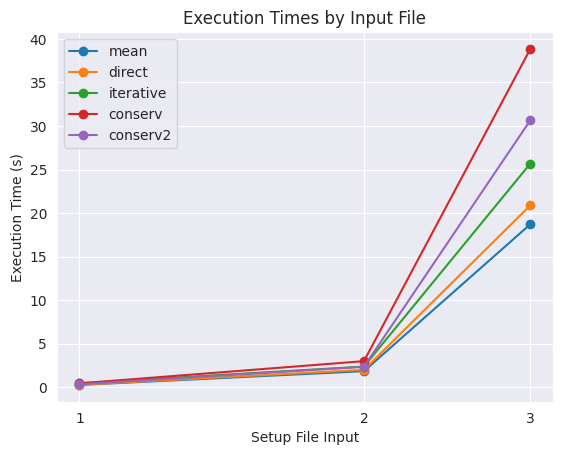

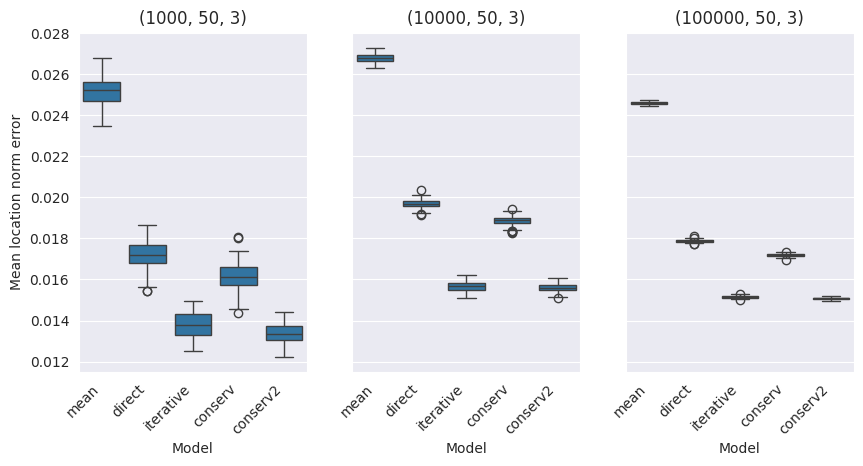

In [5]:
# Plots execution time (Fig.1) and metric comparison (Fig.2)
# Chooses the methods
methods = {"mean": OneShotMean(),
          "direct":OneShotDirect(), 
          "iterative":OneShotIterative(),
          "conserv":OneShotConservative(),
          "conserv2":OneShotConservative2(),
          # "10shot-1.1":KShot(greediness=1.1),
          # "10shot-1.4":KShot(greediness=1.4)
         }

# Compare the methods within the setup files
run_and_plot(['np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl','np_10000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl','np_100000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl'], methods)

Computing np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl
Computing np_10000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl
Computing np_100000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl


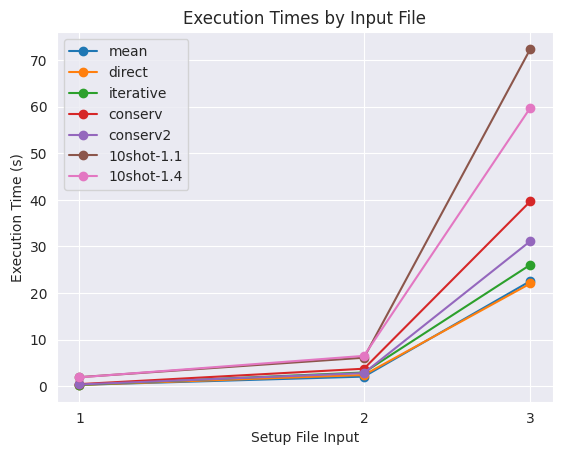

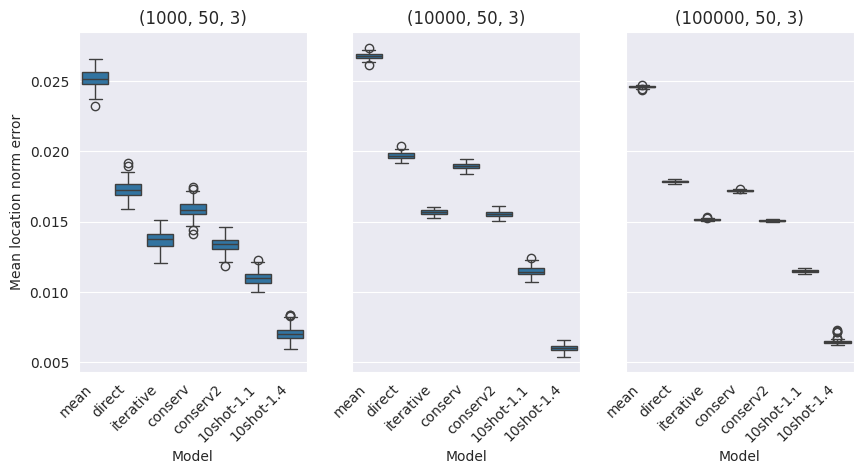

In [6]:
# Plot execution time (Fig. 8) and metric comparison (Fig.9)
# Chooses the methods
methods = {"mean": OneShotMean(),
          "direct": OneShotDirect(),
          "iterative": OneShotIterative(),
          "conserv": OneShotConservative(),
          "conserv2": OneShotConservative2(),
          "10shot-1.1":KShot(greediness=1.1),
          "10shot-1.4":KShot(greediness=1.4)
          }

# Compares the methods within the setup files
run_and_plot(['np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl', 'np_10000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl',
     'np_100000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl'], methods)

In [7]:
# Create setup files for different number of annotations per point
number_of_points = 1000
number_of_annotators = 50
redundancy = [3, 5, 10]
points_distribution = 'uniform'
sigma_distribution = 'uniform'

for redundancy_value in redundancy:
    save_experiment_setup([number_of_points, number_of_annotators, redundancy_value, points_distribution, sigma_distribution])

Computing np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl
Computing np_1000_na_50_rd_5_sd_uniform_pd_uniform_setup.pkl
Computing np_1000_na_50_rd_10_sd_uniform_pd_uniform_setup.pkl


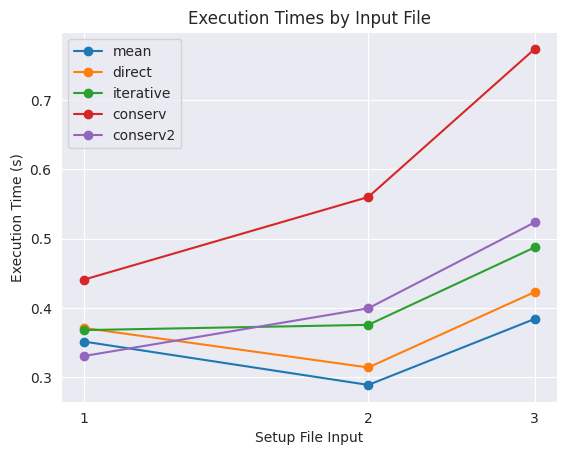

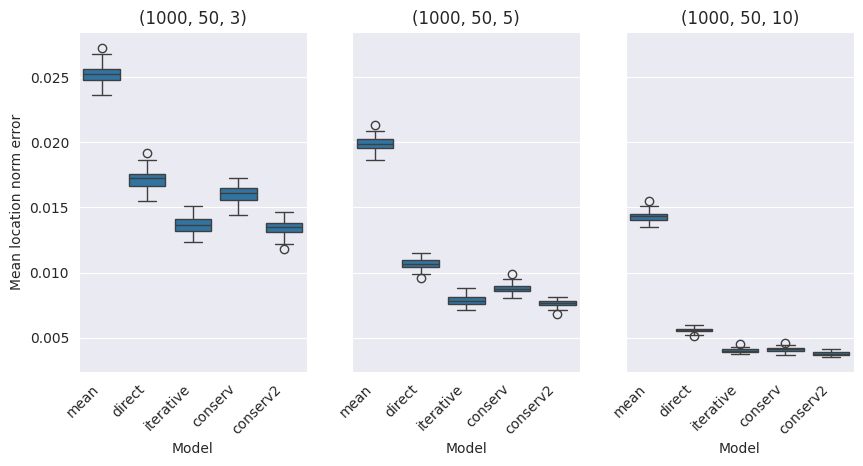

In [8]:
# Plot execution time and metric comparison (Fig.3)
# Chooses the methods
methods = {"mean": OneShotMean(),
          "direct":OneShotDirect(), 
          "iterative":OneShotIterative(),
          "conserv":OneShotConservative(),
          "conserv2":OneShotConservative2(),
          # "10shot-1.1":KShot(greediness=1.1),
          # "10shot-1.4":KShot(greediness=1.4)
         }

# Compares the methods within the setup files
run_and_plot(['np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl','np_1000_na_50_rd_5_sd_uniform_pd_uniform_setup.pkl','np_1000_na_50_rd_10_sd_uniform_pd_uniform_setup.pkl'], methods)

In [9]:
def necessary_budget_continuous(setup_file, methods):
    '''
    takes a str: setup file as argument and compare the methods based on this setup to find how much redundany is needed 
    to achieve a same value of error for each model, then plot the results
    '''
    params=load_experiment_setup(setup_file) #open setup file
    #np.random.seed(params[7])
    
    name_list=list(methods.keys())
    metrics = {"mean_location_norm_error":mean_location_norm_error}
    #"mean_sigma_norm_error":mean_sigma_norm_error}
    
    n_points,n_annotators,redundancy=(params[0],params[1],params[2]) #choice of general parameters
    sig_distr=params[3] #choice of the sigma distrib
    if sig_distr=='uniform':
        annotator_population = SimpleNormalAnnotatorPopulation(uniform(scale=0.1))
    if sig_distr=='beta':
        annotator_population = SimpleNormalAnnotatorPopulation()
    
    points=params[5]
    sigmas = params[6]
    ann_set = annotator_population.sample(n_annotators)
    for k,elem in enumerate(ann_set.annotators): #we put the setup sigmas
        elem._sigma=sigmas[k]
    

    model_curves=[]
    for model_name, m in methods.items():
        print(f"Computing {model_name} method")
        error_list=[]
        for redundancy in range(2,40):
            results=[]
            exp = ActiveAnnotationContest(points, ann_set, max_total_annotations=n_points*redundancy)
            repeats=60
            result = {"model": model_name}
            for i in range(repeats):
                exp.reset()
                this_run = m.run(exp)
                result["iteration"] = i
                for metric_name, metric in metrics.items():
                    result["metric"] = metric_name
                    result["value"] = metric(exp, this_run)
                    results.append(result.copy())
                
        
            metrics_value=np.mean(np.array([results[i]['value'] for i in range(0,len(results),2)]))
            error_list.append(metrics_value)
     
        model_curves.append([[k for k in range(2,40)],np.array([k for k in error_list])])
        
            
    fig=plt.figure()
    ax = fig.add_subplot(111)
    for k,elem in enumerate(model_curves):
        if name_list[k]=="10shot-1.1" or name_list[k]=="10shot-1.4" :
            ax.plot(elem[1],elem[0],label=name_list[k])
        else:
            ax.plot(elem[1],elem[0],label=name_list[k],linestyle="dashed")
        
   
    ax.set_xlabel("error values") 
    
    
    #inversed axis
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("redundancy") 

    plt.legend()
    plt.xscale('log')
    plt.show()

Computing mean method
Computing direct method
Computing iterative method
Computing conservative method
Computing conservative2 method


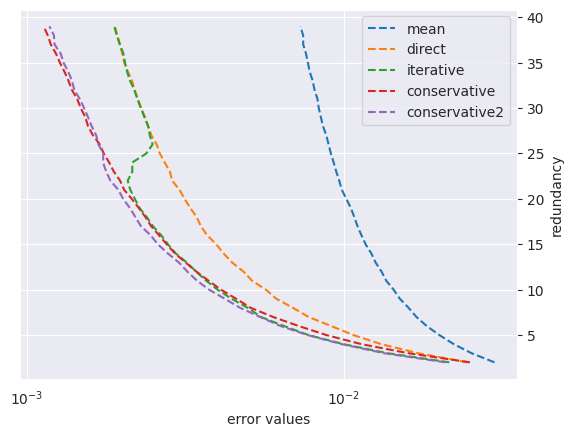

In [10]:
# Plots metric error depending on the redundancy value (Fig. 4)
# Chooses the methods
methods = {"mean": OneShotMean(),
          "direct":OneShotDirect(), 
          "iterative":OneShotIterative(),
          "conservative":OneShotConservative(),
          "conservative2":OneShotConservative2(),
          # "10shot-1.1":KShot(greediness=1.1),
          # "10shot-1.4":KShot(greediness=1.4)
         }

# Compares the methods within the setup file
necessary_budget_continuous('np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl', methods)

Computing mean method
Computing direct method
Computing iterative method
Computing conservative method
Computing conservative2 method
Computing 10shot-1.1 method
Computing 10shot-1.4 method


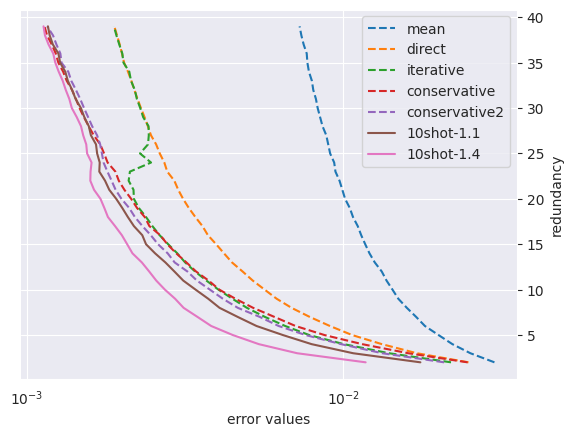

In [11]:
# Plots metric error depending on the redundancy value (Fig. 11)
# Chooses the methods
methods = {"mean": OneShotMean(),
          "direct":OneShotDirect(), 
          "iterative":OneShotIterative(),
          "conservative":OneShotConservative(),
          "conservative2":OneShotConservative2(),
          "10shot-1.1":KShot(greediness=1.1),
          "10shot-1.4":KShot(greediness=1.4)
         }

# Compares the methods within the setup file
necessary_budget_continuous('np_1000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl', methods)

In [12]:
def greediness_impact(setup_file, greediness_list):
    '''
    takes a list of greediness to test and a setup file and plot the location error depending on greediness
    '''
     
    list_df=[]
    methods = {}
    for greediness in greediness_list:
        methods[f"greed={greediness}"] = KShot(greediness=greediness)
    metrics = {"mean_location_norm_error":mean_location_norm_error}
    
    name_list=list(methods.keys())
    new_labels=[k[6:] for k in name_list]
    # print(name_list)
    
    params=load_experiment_setup(setup_file) #get the params from the setup file
        
    random.seed(params[7])
        
    n_points,n_annotators,redundancy=(params[0],params[1],params[2])
        
    #points = point_distribution.rvs(n_points)
    points = params[5]   
    sigmas = params[6]
        
    annotator_population = SimpleNormalAnnotatorPopulation(uniform(scale=0.1)) #here we decide the distribution of sigmas
        
    ann_set = annotator_population.sample(n_annotators) #not usefull because already have sigmas*
    for k,elem in enumerate(ann_set.annotators): #we put the setup sigmas
        elem._sigma=sigmas[k]
       
    
    exp = ActiveAnnotationContest(points, ann_set, max_total_annotations=n_points*redundancy)
    results = compare(methods, exp, metrics, 50)[0]
    df=pd.DataFrame(results)
    list_df.append(df)
 
    #create the box plot
    fig, axs = plt.subplots(1,1, figsize=(10, 5),sharey=True)
    for i, elem in enumerate(list_df):
        sn.boxplot(data=elem[elem["metric"]=="mean_location_norm_error"], x="model", y="value", ax=axs,boxprops=dict(facecolor='none', edgecolor='black', linewidth=1.5))
    
        #axs.set_title(str(int_tuple))
        axs.set(xlabel="greediness", ylabel="Mean_location_norm_error")
        # axs.set_xticklabels(new_labels)
    fig.autofmt_xdate(rotation=45)

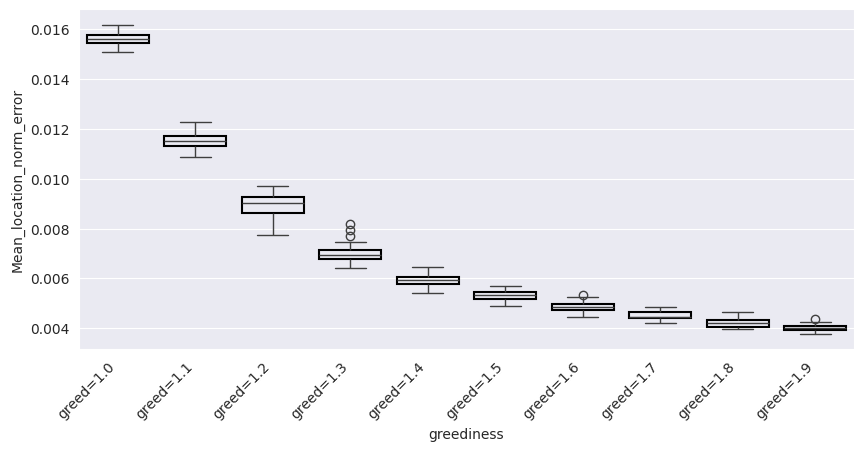

In [13]:
# Plots metric error depending on the level of greediness (Fig. 12)
greediness_impact("np_10000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl", [k/10 for k in range(10,20)])

In [14]:
# To obtain plain predictions of a given experiment

In [15]:
def tok(nb_points):
    '''function to create the tokyo distribution array'''
    tab=sample_tokyo_latitudes(nb_points)
    tab=(tab-np.min(tab))/(np.max(tab)-np.min(tab))
    return(tab)

In [16]:
def runexp(setup_file, methods):

    '''
    takes a str: setup file name as argument and compare the methods based on this setup
    '''

    params=load_experiment_setup(setup_file) #open setup file
    np.random.seed(params[7])

    metrics = {"mean_location_norm_error":mean_location_norm_error,
          "mean_sigma_norm_error":mean_sigma_norm_error}

    n_points,n_annotators,redundancy=(params[0],params[1],params[2]) #choice of general parameters
    sig_distr=params[3] #choice of the sigma distrib
    if sig_distr=='uniform':
        annotator_population = SimpleNormalAnnotatorPopulation(uniform(scale=0.1))
    if sig_distr=='beta':
        annotator_population = SimpleNormalAnnotatorPopulation()

    point_distr=params[4] #choice of point distrib

    if point_distr=='uniform':
        point_distribution = uniform()
        points = point_distribution.rvs(n_points)
    else:
        points =  tok(n_points)

    list_tru_sig=[]
    ann_set = annotator_population.sample(n_annotators)
    list_true_sig=[ann_set.annotators[k]._sigma for k in range(len(ann_set.annotators))]

    exp = ActiveAnnotationContest(points, ann_set, max_total_annotations=n_points*redundancy)
    list_sigm_pred=[]
    list_point_pred=[]
    for model_name, m in methods.items():
        print(model_name)
        result = {"model": model_name}
        exp.reset()
        this_run = m.run(exp)
        locations=this_run["locations"]
        sigmas=this_run["sigmas"]
        list_sigm_pred.append(sigmas)
        list_point_pred.append(locations)
    return points,list_true_sig,list_point_pred,list_sigm_pred

In [17]:
methods = {#"mean": OneShotMean(),
          "direct":OneShotDirect(), 
          #"iterative":OneShotIterative(), 
          "conservative2":OneShotConservative2(),
          #"conservative":OneShotConservative(),
          "10shot":KShot(greediness=1.2)
         }

true_points, true_errors, pred_points, pred_errors = runexp('np_10000_na_50_rd_3_sd_uniform_pd_uniform_setup.pkl', methods)

direct
conservative2
10shot


In [18]:
print(f"Predicted points: {pred_points}")
print("--------------------------------")
print(f"Predicted errors: {pred_errors}")

Predicted points: [array([0.02455023, 0.3888061 , 0.39395066, ..., 0.86311592, 0.9058761 ,
       0.10135932]), array([0.07880598, 0.31956992, 0.38912193, ..., 0.84317793, 0.87417332,
       0.12092009]), array([0.08157746, 0.35788721, 0.39888639, ..., 0.83148551, 0.88130136,
       0.11950717])]
--------------------------------
Predicted errors: [array([0.04048423, 0.03834527, 0.04798733, 0.04076806, 0.03447398,
       0.02858323, 0.03857778, 0.05396794, 0.05583237, 0.02703693,
       0.02626093, 0.02335937, 0.03421111, 0.05747896, 0.04303157,
       0.02768125, 0.0293062 , 0.02560793, 0.06783181, 0.04775079,
       0.04947228, 0.03768648, 0.03916723, 0.0329506 , 0.03219229,
       0.03873963, 0.0358455 , 0.03873827, 0.06213979, 0.03217316,
       0.06117747, 0.02868124, 0.07138601, 0.04652316, 0.05604161,
       0.04079394, 0.0260943 , 0.02757106, 0.03003131, 0.02345478,
       0.03034692, 0.04413172, 0.03783914, 0.02780972, 0.06325882,
       0.03467627, 0.03375637, 0.02275055, 0.02